# Evaluating the NHANES audiogram generator
Data-driven approaches to audiogram synthesis could allow for sharing of simulated but valid data. As the PTA dataset was drawn from actual PTA tests, they represent real estimated hearing levels. The data provides indication of proportion of different types of audiogram curve and with that, different forms of hearing loss.

Additionally, the associations between audiogram curve shapes and demographic factors can be maintained, linking gender, age and race/ethnicity to the audiogram synthesis. Data synthesis approaches provide discrete observations (the synthesised data) from probabilistic models of the data. Here, a kernel density estimation (KDE) was made of the entire NHANES cohort to provide a probabilistic model of the data from which synthetic data could be sampled from.

Here we train KDE models of various types on the NHANES data and test the simulated data's validity.

PTA synthesisers are assessed through multiple metrics to provide a holistic estimate of the synthesisers' validity. Uni- and multi-variate distributional similarity tests are considered.

For univariate testing, where the distribution across observations of a single feature is considered, the **Kolmogorov-Smirnov Test** is applied. Thus, the original observations for hearing level of a given pure-tone are compared against the synthetic observations.

Additionally, correlation coefficients between original and synthesised features are compared.

For considering the similarity of the synthetic data across multidimensional planes, the **Hotelling's $T^2$ test** is applied. This test allows for identification of dissimilar distributions across joint probabilities. 

## Load modules & specify environment parameters

In [1]:
# import modules
import os
import warnings
import pickle

import pandas as pd
import numpy as np

import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import f
from scipy.stats import ks_2samp


# Needed for plotting
import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
import seaborn as sns

# Needed for generating data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [2]:
# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Change dir to NHANES data
os.chdir('../data')

# Set plotting params
sns.set(rc={"figure.figsize":(15 , 9 )})
sns.set(font_scale=1.5, style="whitegrid")

# Set random seed for reproducibility
np.random.seed(26)

## Define Functions

In [3]:
# data prep functions
def wide_pta_to_long_with_ear(nhanes_pta):
    """Process Pure Tone Audiometry (PTA) data from NHANES dataset with 
    wide format to long format with ear codes.

    Args:
        nhanes_pta (DataFrame): DataFrame containing PTA data.

    Returns:
        DataFrame: Processed PTA data DataFrame with columns: 'Hearing Threshold (dB HL)', 'Ear', 'Frequency (Hz)'.
    """

    # Create an empty Pandas DataFrame for storing processed PTA data
    ear_nhanes_pta = pd.DataFrame()

    # Iterate over columns in the original dataset (nhanes_pta)
    for i in nhanes_pta.columns:
        # Determine whether the ear is Right or Left based on column names
        if i.endswith('Right'):
            ear = 'Right'
        elif i.endswith('Left'):
            ear = 'Left'
        else:
            # Skip columns that do not represent Right or Left ear data
            continue

        # Extract the frequency information from the column name
        for j in range(9):
            if i.split(' ')[0][0] == str(j):
                if j == 0:
                    frequency = 500
                else:
                    frequency = j * 1000

        # Extract hearing threshold values for the specific ear and frequency
        pta_values = nhanes_pta[i].to_frame()
        ear_nhanes_pta_i = pta_values.copy()
        ear_nhanes_pta_i.columns = ['Hearing Threshold (dB HL)']
        ear_nhanes_pta_i['Ear'] = np.full((nhanes_pta.shape[0], 1), ear)
        ear_nhanes_pta_i['Frequency (Hz)'] = np.full((nhanes_pta.shape[0], 1), frequency)
        ear_nhanes_pta_i['Hearing Loss'] = nhanes_pta['Hearing Loss']

        # Append the processed data to the ear_nhanes_pta DataFrame
        if ear_nhanes_pta.empty:
            ear_nhanes_pta = ear_nhanes_pta_i
        else:
            # Concatenate DataFrames based on frequency, prioritizing 500 Hz data
            if frequency == 500:
                ear_nhanes_pta = pd.concat([ear_nhanes_pta_i, ear_nhanes_pta], axis=0)
            else:
                ear_nhanes_pta = pd.concat([ear_nhanes_pta, ear_nhanes_pta_i], axis=0)

    # Replace infinite values with NaN and reset the index of the resulting DataFrame
    ear_nhanes_pta.replace([np.inf, -np.inf], np.nan, inplace=True)
    ear_nhanes_pta.reset_index(inplace=True, drop=True)

    # Remove rows corresponding to 3000 and 6000 Hz frequencies
    ear_nhanes_pta = ear_nhanes_pta[~ear_nhanes_pta['Frequency (Hz)'].isin([3000, 6000])]

    return ear_nhanes_pta

def process_demo_pta_data(nhanes_demo_pta_df, ordered_nhanes_pta):
    """Process Pure Tone Audiometry (PTA) data from NHANES demographic dataset.

    Args:
        nhanes_demo_pta_df (DataFrame): DataFrame containing demographic data with PTA information.
        ordered_nhanes_pta (DataFrame): DataFrame containing ordered PTA data.

    Returns:
        DataFrame: Processed PTA data DataFrame with columns: 'SEQN', 'Hearing Threshold (dB HL)', 'Frequency (Hz)',
                   'Ear', 'Gender', 'Age (years)', 'Race/ethnicity'.
    """

    # Create an empty Pandas DataFrame for storing processed PTA data
    nhanes_demo_pta_long_df = pd.DataFrame()

    # Iterate over columns in the ordered PTA dataset
    for i in ordered_nhanes_pta.columns:
        # Extract frequency and ear information from the column name
        for j in range(9):
            if i.split(' ')[0][0] == str(j):
                if j == 0:
                    frequency = 500
                else:
                    frequency = j * 1000
            if i.split(' ')[1] == 'Right':
                ear = 'Right'
            elif i.split(' ')[1] == 'Left':
                ear = 'Left'

        # Extract hearing threshold values for the specific ear and frequency
        pta_values = nhanes_demo_pta_df[i].to_frame()
        nhanes_demo_pta_long_i = nhanes_demo_pta_df['SEQN'].to_frame()
        nhanes_demo_pta_long_i['Hearing Threshold (dB HL)'] = pta_values.copy()
        nhanes_demo_pta_long_i['Frequency (Hz)'] = np.full((nhanes_demo_pta_df.shape[0], 1), frequency)
        nhanes_demo_pta_long_i['Ear'] = np.full((nhanes_demo_pta_df.shape[0], 1), ear)
        nhanes_demo_pta_long_i['Gender'] = nhanes_demo_pta_df['Gender']
        nhanes_demo_pta_long_i['Age (years)'] = nhanes_demo_pta_df['Age (years)']
        nhanes_demo_pta_long_i['Race/ethnicity'] = nhanes_demo_pta_df['Race/ethnicity']

        # Append the processed data to the nhanes_demo_pta_long_df DataFrame
        if nhanes_demo_pta_long_df.empty:
            nhanes_demo_pta_long_df = nhanes_demo_pta_long_i
        else:
            # Concatenate DataFrames based on frequency, prioritizing 500 Hz data
            if frequency == 500:
                nhanes_demo_pta_long_df = pd.concat([nhanes_demo_pta_long_i, nhanes_demo_pta_long_df], axis=0)
            else:
                nhanes_demo_pta_long_df = pd.concat([nhanes_demo_pta_long_df, nhanes_demo_pta_long_i], axis=0)

    # Replace infinite values with NaN and reset the index of the resulting DataFrame
    nhanes_demo_pta_long_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    nhanes_demo_pta_long_df.reset_index(inplace=True, drop=True)

    # Remove rows corresponding to 3000 and 6000 Hz frequencies
    nhanes_demo_pta_long_df = nhanes_demo_pta_long_df[~nhanes_demo_pta_long_df['Frequency (Hz)'].isin([3000, 6000])]

    return nhanes_demo_pta_long_df

def get_hearing_loss_info_and_code(pta_data):
    """
    Analyze Pure Tone Audiometry (PTA) data to identify individuals with hearing loss.

    This function takes PTA data as input, identifies individuals with a hearing level
    greater than 25 dB HL as having hearing loss, and adds a corresponding code to the dataset.

    Args:
        pta_data (DataFrame): A pandas DataFrame containing PTA data for individuals.

    Returns:
        tuple: A tuple containing the modified DataFrame with a new 'Hearing Loss' column
               and the number of individuals identified with hearing loss.
    """
    # Copy the input DataFrame to avoid modifying the original data
    pta_data_copy = pta_data.copy()

    # Identify hearing loss (True for hearing level > 25 dB HL)
    pta_hearing_loss = pta_data_copy > 25

    # Initialize counters and index list for individuals with hearing loss
    n_people_with_hl = 0
    idx_of_hl = []

    # Iterate through the DataFrame to count individuals with hearing loss
    for _, row in pta_hearing_loss.iterrows():
        if row.sum() > 0:  # If any value in row indicates hearing loss
            n_people_with_hl += 1
            idx_of_hl.append(1)
        else:
            idx_of_hl.append(0)

    # Add the hearing loss code to the original DataFrame
    pta_data_copy['Hearing Loss'] = idx_of_hl

    return pta_data_copy, n_people_with_hl


In [4]:
# visualisation functions
def agg_audiogram_curve(pta_long_df):
    pta_long_normal_df = pta_long_df[pta_long_df['Hearing Loss'] == 0]
    pta_long_hearingLoss_df = pta_long_df[pta_long_df['Hearing Loss'] == 1]
        
    pal = sns.color_palette("Paired")

    custom_lines = [Line2D([0], [0], color=pal[0], marker='x', linestyle='-', lw=3, markersize=10, markeredgewidth=2),
                    Line2D([0], [0], color=pal[1], marker='o',linestyle='-', lw=3, markersize=10),
                    Line2D([0], [0], color=pal[2], marker='x', linestyle='--', lw=3, markersize=10, markeredgewidth=2),
                    Line2D([0], [0], color=pal[3], marker='o', linestyle='--', lw=3, markersize=10),
                    Line2D([0], [0], color=pal[4], marker='x', linestyle='-.', lw=3, markersize=10, markeredgewidth=2),
                    Line2D([0], [0], color=pal[5], marker='o', linestyle='-.', lw=3, markersize=10)]

    sns.set(font_scale=1.5, style="whitegrid")
    fig, ax = plt.subplots()

    sns.pointplot(data=pta_long_df,
                ax=ax,
                    x="Frequency (Hz)",
                    y="Hearing Threshold (dB HL)",
                    hue="Ear",
                    markers=["x", "o"],
                    linestyles=["-", "-"],
                    palette=[pal[0], pal[1]],
                    capsize=.1,
                    errorbar=None,
                    dodge=True)

    sns.pointplot(data=pta_long_normal_df,
                ax=ax,
                    x="Frequency (Hz)",
                    y="Hearing Threshold (dB HL)",
                    hue="Ear",
                    markers=["x", "o"],
                    linestyles=["--", "--"],
                    palette=[pal[2], pal[3]],
                    capsize=.1,
                    errorbar=None,
                    dodge=True)

    sns.pointplot(data=pta_long_hearingLoss_df,
                ax=ax,
                    x="Frequency (Hz)",
                    y="Hearing Threshold (dB HL)",
                    hue="Ear",
                    markers=["x", "o"],
                    linestyles=["-.", "-."],
                    palette=[pal[4], pal[5]],
                    capsize=.1,
                    errorbar=None,
                    dodge=True)


    plt.xticks(np.arange(5))
    plt.yticks(np.arange(-5, 65, 10))
    plt.grid(visible=True, which='both')
    plt.ylim((-10, 65))
    plt.gca().invert_yaxis()
    ax.legend(custom_lines,
            ['Left Ear - Whole Sample',
            'Right Ear - Whole Sample',
            'Left Ear - Normal Sample',
            'Right Ear - Normal Sample',
            'Left Ear - Hearing Loss Sample',
            'Right Ear - Hearing Loss Sample',],
            ncols=3,
            loc='best', bbox_to_anchor=(1, -0.1))

    sns.despine()
    
    return fig, ax 

In [5]:
# model eval functions
def print_kde_params(kde_model):
    algorithm = kde_model.tree_
    n_features = kde_model.n_features_in_
    bandwidth = kde_model.bandwidth_
    leaf_size = kde_model.leaf_size
    metric = kde_model.metric
    print(f'A KDE model was trained with {n_features} input features using the {algorithm} algorithm.\nThe model used a bandwidth of $H = {bandwidth}$, leaf size of {leaf_size} and, optimised via the {metric} distance metric.')
    return

def TwoSampleT2Test(X, Y): # from https://www.r-bloggers.com/2020/10/hotellings-t2-in-julia-python-and-r/
    nx, p = X.shape
    ny, _ = Y.shape
    delta = np.mean(X, axis=0) - np.mean(Y, axis=0)
    Sx = np.cov(X, rowvar=False)
    Sy = np.cov(Y, rowvar=False)
    S_pooled = ((nx-1)*Sx + (ny-1)*Sy)/(nx+ny-2)
    t_squared = (nx*ny)/(nx+ny) * np.matmul(np.matmul(delta.transpose(), np.linalg.inv(S_pooled)), delta)
    statistic = t_squared * (nx+ny-p-1)/(p*(nx+ny-2))
    F = f(p, nx+ny-p-1)
    p_value = 1 - F.cdf(statistic)
    print(f"Test statistic: {statistic}\nDegrees of freedom: {p} and {nx+ny-p-1}\np-value: {p_value}")
    return statistic, p_value

## Load in PTA data

In [6]:
# load in data
nhanes_demo_pta_HL_df = pd.read_csv('nhanes_1999to2020_demo_pta_hearingLoss.csv')

# drop nan's
nhanes_demo_pta_HL_dropNa_df = nhanes_demo_pta_HL_df.dropna()

# get just pta data
nhanes_pta_dropNa_df = nhanes_demo_pta_HL_dropNa_df.iloc[:, 1:11]

# create long dataset
nhanes_demo_pta_HL_dropNa_long_df = process_demo_pta_data(nhanes_demo_pta_HL_dropNa_df, nhanes_pta_dropNa_df)

In [7]:
nhanes_demo_pta_HL_df

,SEQN,0.5kHz Right,0.5kHz Left,1kHz Right,1kHz Left,2kHz Right,2kHz Left,4kHz Right,4kHz Left,8kHz Right,8kHz Left,Gender,Age (years),Race/ethnicity,Hearing Loss
0,10.0,10.0,10.0,5.0,5.0,10.0,20.0,15.0,10.0,10.0,15.0,Male,43.0,Non-Hispanic Black,0
1,15.0,0.0,0.0,-5.0,10.0,-5.0,5.0,-5.0,5.0,10.0,5.0,Female,38.0,Non-Hispanic White,0
2,24.0,10.0,10.0,15.0,15.0,15.0,20.0,20.0,25.0,25.0,15.0,Female,53.0,Non-Hispanic White,0
3,45.0,5.0,0.0,0.0,-5.0,0.0,-5.0,5.0,10.0,10.0,0.0,Female,33.0,Mexican American,0
4,56.0,5.0,10.0,20.0,20.0,35.0,40.0,20.0,30.0,10.0,15.0,Male,21.0,Non-Hispanic White,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29709,124797.0,NaN,NaN,5.0,0.0,5.0,-5.0,0.0,5.0,0.0,10.0,Male,9.0,Mexican American,0
29710,124799.0,25.0,20.0,30.0,40.0,40.0,45.0,55.0,60.0,NaN,NaN,Female,80.0,Non-Hispanic White,1
29711,124811.0,30.0,35.0,20.0,30.0,5.0,15.0,15.0,25.0,45.0,60.0,Male,76.0,Non-Hispanic White,1
29712,124820.0,NaN,NaN,5.0,5.0,5.0,10.0,0.0,10.0,30.0,15.0,Female,7.0,Non-Hispanic White,1


## Train & evaluate models

### Simple best model via grid search

Train

In [8]:
# prepare pta data for generation
X = nhanes_pta_dropNa_df.to_numpy() # use all nhanes pta data (both people with and without hearing loss) - no demographics

# Fit a kernel density model using GridSearchCV to determine the best parameter for bandwidth
bandwidth_params = {'bandwidth': np.arange(0.01,1,0.05)}
grid_search = GridSearchCV(KernelDensity(), bandwidth_params)
grid_search.fit(X)
kde = grid_search.best_estimator_

print_kde_params(kde)

A KDE model was trained with 10 input features using the <sklearn.neighbors._kd_tree.KDTree object at 0x12a7dd210> algorithm.
The model used a bandwidth of $H = 0.9600000000000001$, leaf size of 40 and, optimised via the euclidean distance metric.


In [15]:
# Save the model to a file
with open('../models/kde_nhanes1999_2020_randSeed26_model.pkl', 'wb') as f:
    pickle.dump(kde, f)

In [ ]:
# Load in pre-trained KDE model
kde = pickle.load(open('../models/kde_nhanes1999_2020_randSeed26_model.pkl', 'rb'))

Sample from KDE

In [9]:
# get 100,000 samples from KDE
sim_pta_100k_floating = kde.sample(100000, random_state=26)
sim_pta_100k_multiple5 = np.round((sim_pta_100k_floating/5))*5
sim_pta_100k_multiple5_df = pd.DataFrame(sim_pta_100k_multiple5)
sim_pta_100k_multiple5_df.columns = nhanes_pta_dropNa_df.columns

# add in hearing loss codes to data
sim_pta_100k_hl, n_simulations_with_hl = get_hearing_loss_info_and_code(sim_pta_100k_multiple5_df)
print(f'Sample of 100k simulated audiograms has {n_simulations_with_hl} cases of hearing loss ({(n_simulations_with_hl/1000):.2f}%).')
print(f'The original dataset has {nhanes_demo_pta_HL_df.iloc[:, -1].sum()} cases of hearing loss ({(nhanes_demo_pta_HL_df.iloc[:, -1].sum()/nhanes_demo_pta_HL_df.shape[0])*100:.2f}%).')

Sample of 100k simulated audiograms has 41822 cases of hearing loss (41.82%).
The original dataset has 11607 cases of hearing loss (39.06%).


In [10]:
sim_pta_100k_hl

,0.5kHz Right,0.5kHz Left,1kHz Right,1kHz Left,2kHz Right,2kHz Left,4kHz Right,4kHz Left,8kHz Right,8kHz Left,Hearing Loss
0,15.0,15.0,15.0,10.0,5.0,15.0,15.0,10.0,10.0,15.0,0
1,10.0,5.0,10.0,20.0,15.0,10.0,40.0,30.0,70.0,60.0,1
2,20.0,10.0,30.0,25.0,35.0,30.0,45.0,50.0,50.0,40.0,1
3,10.0,10.0,5.0,5.0,10.0,5.0,5.0,5.0,15.0,5.0,0
4,-0.0,5.0,0.0,-5.0,0.0,-0.0,0.0,-0.0,-0.0,-10.0,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,10.0,15.0,10.0,10.0,15.0,5.0,25.0,20.0,25.0,30.0,1
99996,15.0,0.0,-0.0,10.0,20.0,15.0,15.0,5.0,15.0,5.0,0
99997,20.0,15.0,20.0,20.0,25.0,20.0,10.0,10.0,35.0,5.0,1
99998,10.0,10.0,5.0,15.0,0.0,5.0,15.0,15.0,30.0,20.0,1


In [11]:
# sample wide to long
sim_pta_100k_hl_long = wide_pta_to_long_with_ear(sim_pta_100k_hl)
sim_pta_100k_hl_long

,Hearing Threshold (dB HL),Ear,Frequency (Hz),Hearing Loss
0,15.0,Left,500,0
1,5.0,Left,500,1
2,10.0,Left,500,1
3,10.0,Left,500,0
4,5.0,Left,500,0
...,...,...,...,...
999995,30.0,Left,8000,1
999996,5.0,Left,8000,0
999997,5.0,Left,8000,1
999998,20.0,Left,8000,1


In [12]:
# create 'source' column and concat real and sim data
sim_pta_100k_hl_long_copy = sim_pta_100k_hl_long.copy()
sim_pta_100k_hl_long_copy['Source'] = np.full(sim_pta_100k_hl_long_copy.shape[0], 'Simulated')

nhanes_pta_dropNa_df_copy = wide_pta_to_long_with_ear(get_hearing_loss_info_and_code(nhanes_pta_dropNa_df)[0])
nhanes_pta_dropNa_df_copy['Source'] = np.full(nhanes_pta_dropNa_df_copy.shape[0], 'Real')

nhanes_sim_long = pd.concat([nhanes_pta_dropNa_df_copy, sim_pta_100k_hl_long_copy], axis=0)

Visualise distributions against original dataset

/Users/liambarrett/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.6509803921568628, 0.807843137254902, 0.8901960784313725)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/liambarrett/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.6980392156862745, 0.8745098039215686, 0.5411764705882353)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/liambarrett/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.984313725490196, 0.6039215686274509, 0.6)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of

(<Figure size 1500x900 with 1 Axes>,
 <Axes: xlabel='Frequency (Hz)', ylabel='Hearing Threshold (dB HL)'>)

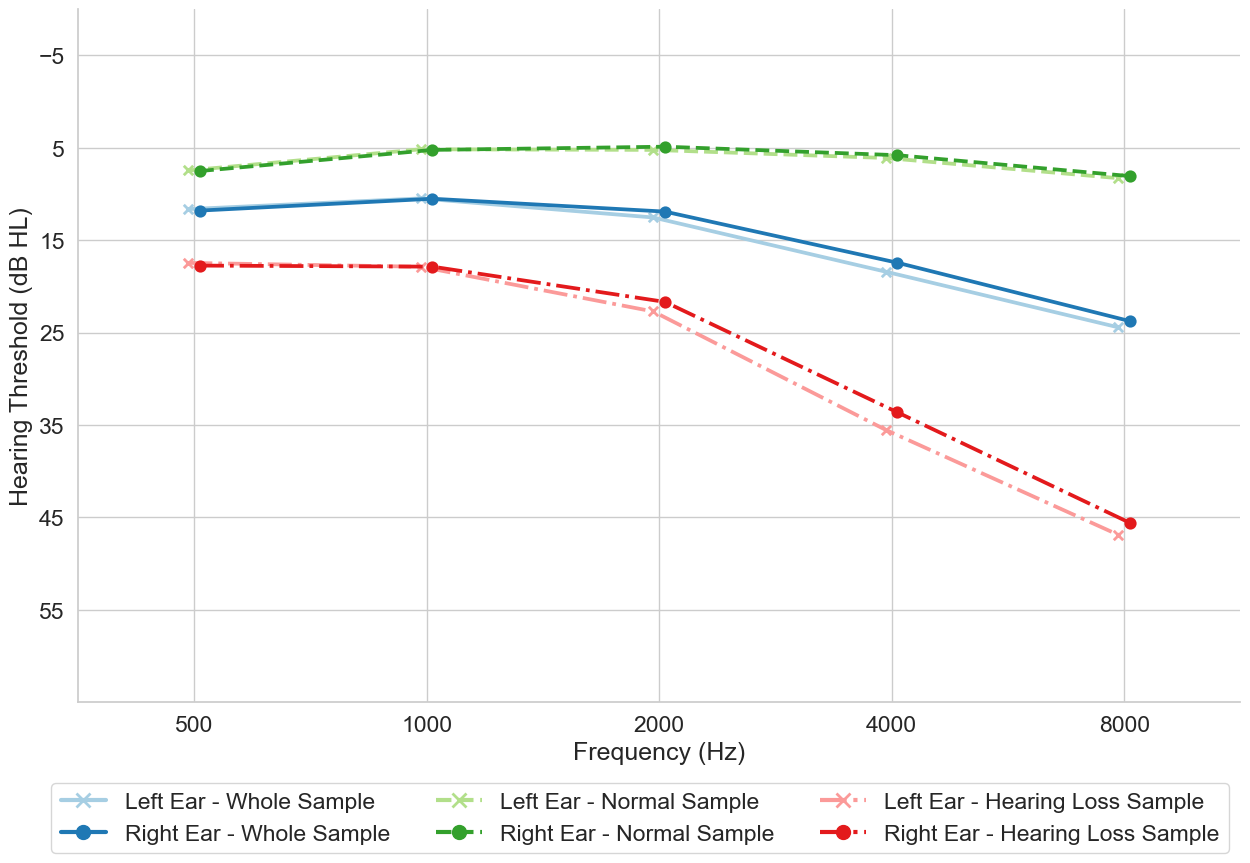

In [13]:
# aggregate audiograms
agg_audiogram_curve(sim_pta_100k_hl_long)

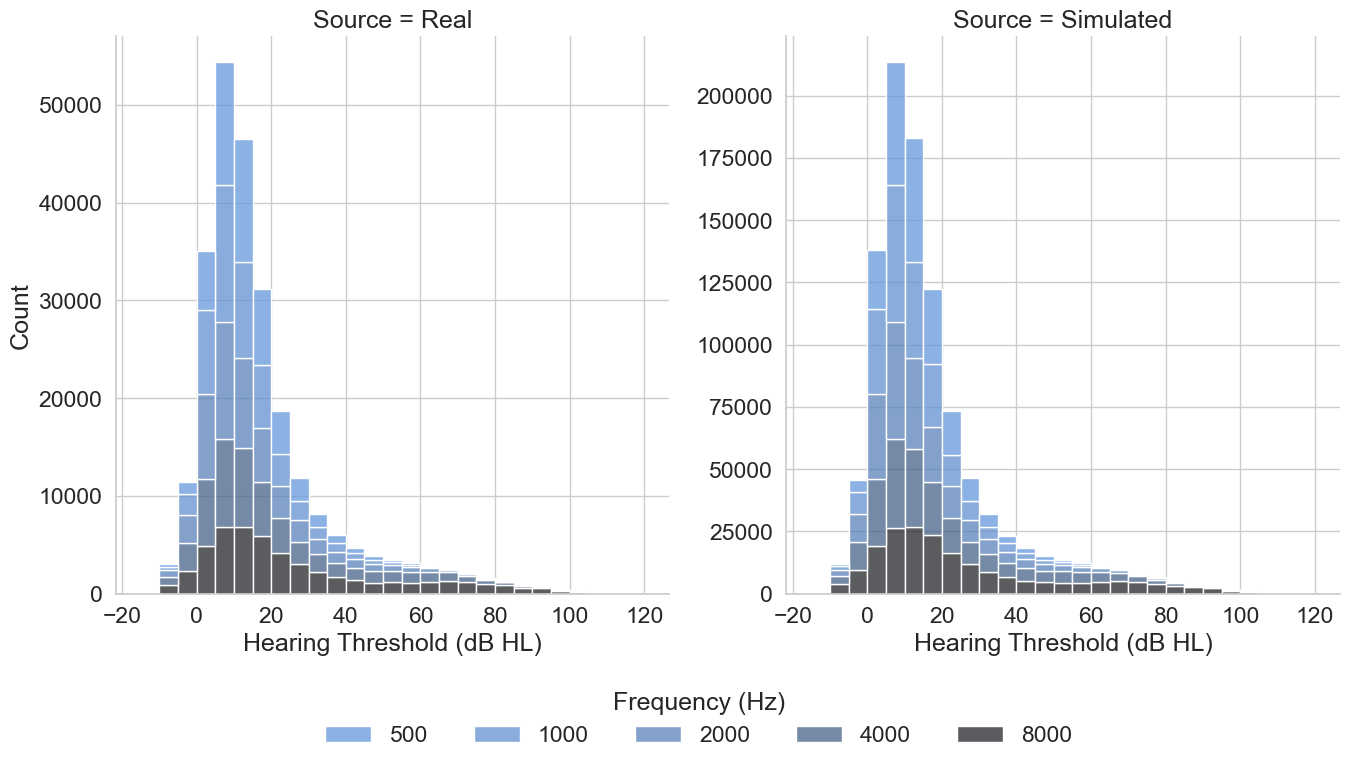

In [34]:
g = sns.displot(nhanes_sim_long, x="Hearing Threshold (dB HL)", hue="Frequency (Hz)",
            col="Source", multiple="stack",
            height=7, palette=sns.dark_palette("#69d", reverse=True, as_cmap=True),
            facet_kws=dict(sharey=False),
            binwidth=5,legend=True)
sns.move_legend(g,
                loc="lower center",
                ncols=5,
                bbox_to_anchor=(0.45, -0.12)
                )
plt.savefig('../figures/synth_real_hearingLevel_distributions.png', dpi=300,  bbox_inches="tight")

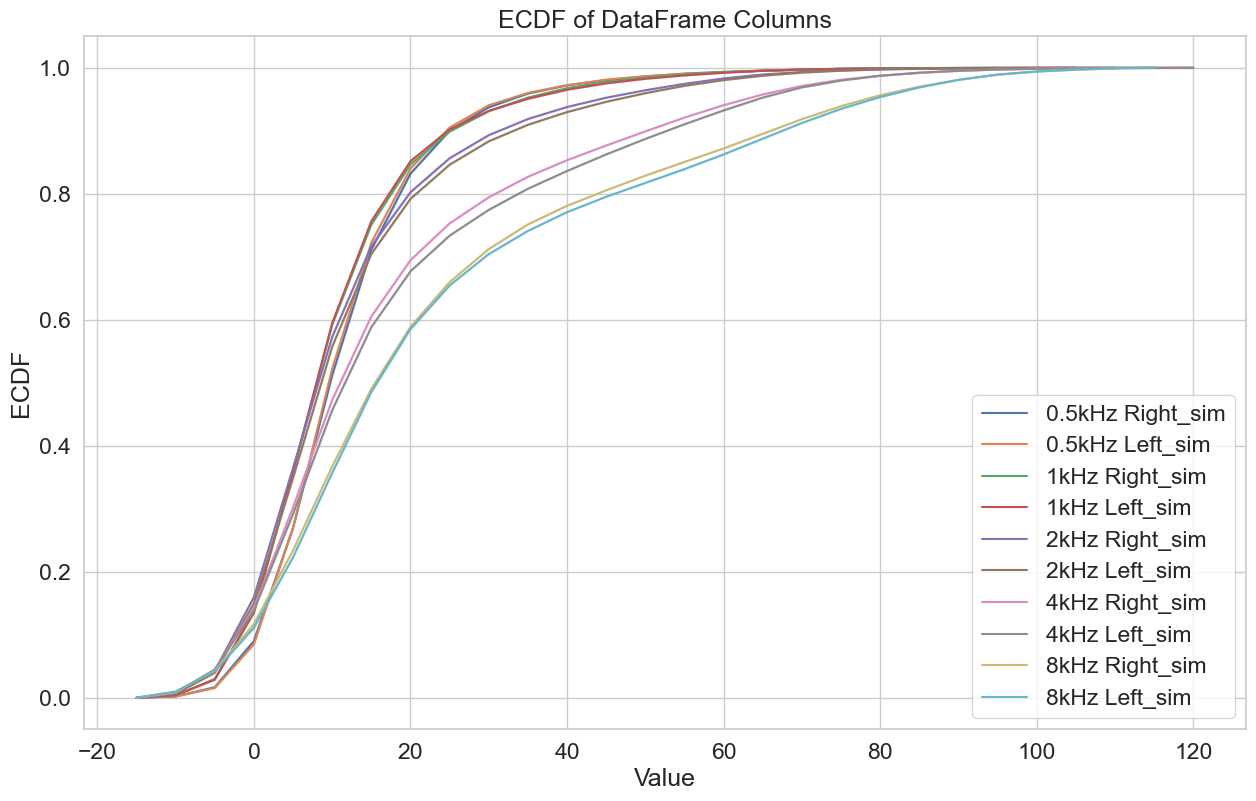

In [58]:
# concat real and simulated data along the N axis
# get 100,000 samples from KDE
sim_pta_100k_floating = kde.sample(100000, random_state=26)
sim_pta_100k_multiple5 = np.round((sim_pta_100k_floating/5))*5
sim_pta_100k_forCorr_df = pd.DataFrame(sim_pta_100k_multiple5)
sim_pta_100k_forCorr_df.columns = nhanes_demo_pta_HL_df.columns[1:11]; sim_pta_100k_forCorr_df.columns = [x+'_sim' for x in sim_pta_100k_forCorr_df.columns]

nhanes_pta_dropNa_df_copy = nhanes_pta_dropNa_df.copy()
nhanes_pta_dropNa_df_copy.columns = [x+'_real' for x in nhanes_pta_dropNa_df_copy.columns]

nhanes_sim_wide = pd.concat([nhanes_pta_dropNa_df_copy, sim_pta_100k_forCorr_df], axis=1)

# Function to calculate ECDF
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points
    n = len(data)
    # x-data for the ECDF: data
    x = np.sort(data)
    # y-data for the ECDF: evenly spaced data points with a maximum of 1
    y = np.arange(1, n+1) / n
    return x, y

# Plotting ECDF for each column
for column in sim_pta_100k_forCorr_df.columns:
    x, y = ecdf(sim_pta_100k_forCorr_df[column])
    sns.lineplot(x=x, y=y, label=column)

plt.title('ECDF of DataFrame Columns')
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.legend()
plt.show()

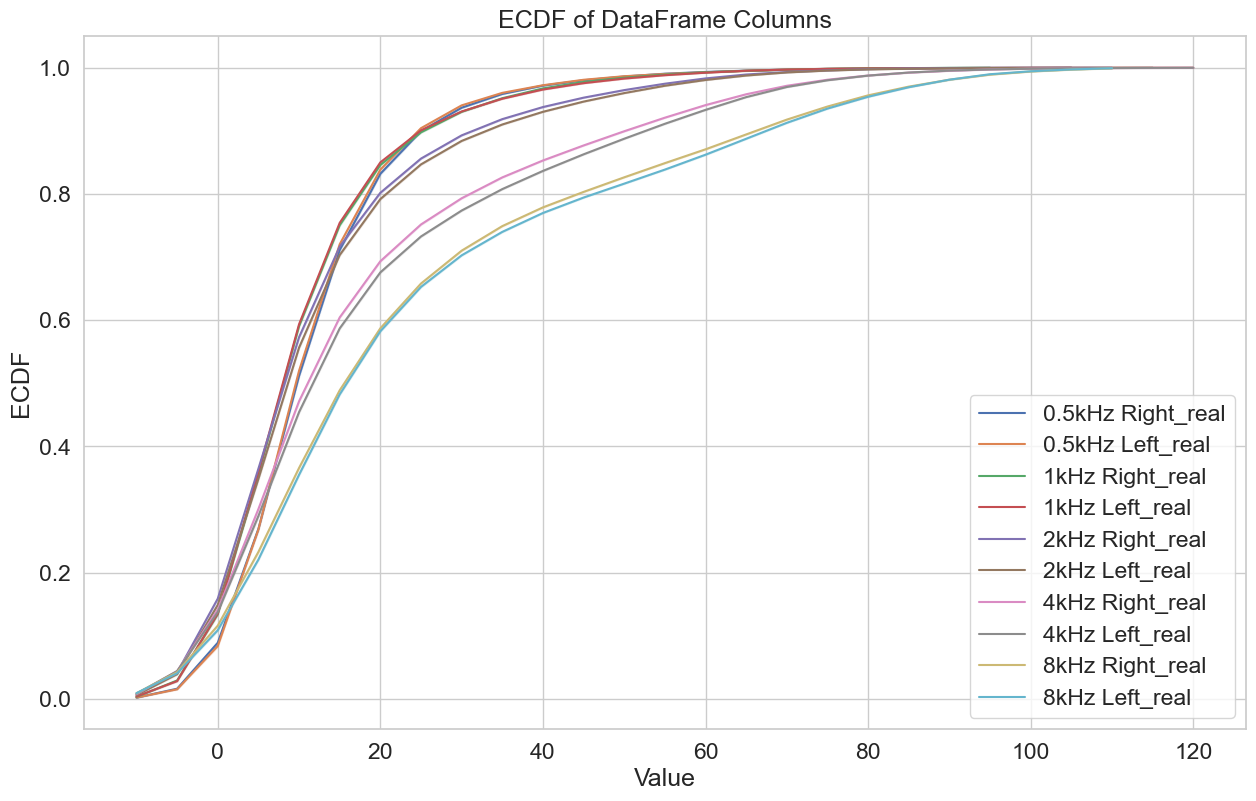

In [59]:
# Plotting ECDF for each column
for column in nhanes_pta_dropNa_df_copy.columns:
    x, y = ecdf(nhanes_pta_dropNa_df_copy[column])
    sns.lineplot(x=x, y=y, label=column)

plt.title('ECDF of DataFrame Columns')
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.legend()
plt.show()

**Run test of one-sided significance**

In [65]:
# this cannot be ran in Python - go to R script
# export df's to use in R
sim_pta_100k_hl.to_csv('sim_data_for_R.csv', index=False)
temp_df = get_hearing_loss_info_and_code(nhanes_pta_dropNa_df)[0]
temp_df.to_csv('nhanes_data_for_R.csv', index=False)

Run correlations between real and simulated data

**Correlations will not work unless N sim = N real data observations**

In [56]:
# concat real and simulated data along the N axis
# get 100,000 samples from KDE
sim_pta_100k_floating = kde.sample(100000, random_state=26)
sim_pta_100k_multiple5 = np.round((sim_pta_100k_floating/5))*5
sim_pta_100k_forCorr_df = pd.DataFrame(sim_pta_100k_multiple5)
sim_pta_100k_forCorr_df.columns = nhanes_demo_pta_HL_df.columns[1:11]; sim_pta_100k_forCorr_df.columns = [x+'_sim' for x in sim_pta_100k_forCorr_df.columns]

nhanes_pta_dropNa_df_copy = nhanes_pta_dropNa_df.copy()
nhanes_pta_dropNa_df_copy.columns = [x+'_real' for x in nhanes_pta_dropNa_df_copy.columns]

correlation_coefficients = nhanes_pta_dropNa_df_copy.corrwith(sim_pta_100k_forCorr_df['0.5kHz Left_sim'], axis=0)

0.5kHz Right_real    0.017991
0.5kHz Left_real     0.013275
1kHz Right_real      0.009100
1kHz Left_real       0.004253
2kHz Right_real      0.008096
2kHz Left_real       0.003606
4kHz Right_real      0.009473
4kHz Left_real       0.005548
8kHz Right_real      0.003817
8kHz Left_real       0.000271
dtype: float64

Run Kolmogorov-Smirnov Test

In [72]:
# Ensure both DataFrames have the same column names and order
assert sim_pta_100k_multiple5_df.columns.equals(nhanes_pta_dropNa_df.columns), "DataFrames columns do not match"

# Initialize a dictionary to store the K-S test results
ks_results = {}

# Iterate over the columns
for column in sim_pta_100k_multiple5_df.columns:
    data1 = sim_pta_100k_multiple5_df[column]
    data2 = nhanes_pta_dropNa_df[column]
    
    # Perform K-S test
    ks_statistic, p_value = ks_2samp(data1, data2)
    
    # Store the results
    ks_results[column] = {'KS Statistic': ks_statistic, 'P-value': p_value}

# Convert the results dictionary to a DataFrame for nicer display
ks_results_df = pd.DataFrame(ks_results).T

# Show the results
print(ks_results_df)


              KS Statistic   P-value
0.5kHz Right      0.000944  1.000000
0.5kHz Left       0.002585  0.999195
1kHz Right        0.002464  0.999660
1kHz Left         0.002325  0.999894
2kHz Right        0.001229  1.000000
2kHz Left         0.001722  1.000000
4kHz Right        0.001482  1.000000
4kHz Left         0.002581  0.999219
8kHz Right        0.002404  0.999789
8kHz Left         0.003626  0.951509


Run Hotelling's $T^2$ test

In [74]:
statistic, p_value = TwoSampleT2Test(sim_pta_100k_multiple5_df.to_numpy(), nhanes_pta_dropNa_df.to_numpy())

Test statistic: 0.20658697168901913
Degrees of freedom: 10 and 125445
p-value: 0.9958095093940574


The Bayes Factor is a Bayesian alternative to traditional hypothesis testing methods, providing a way to quantify the evidence for one model or hypothesis over another using the data at hand. To use the Bayes Factor to test for equivalence between two distributions, you typically compare two hypotheses: the null hypothesis ($H_0$) that the two distributions are equivalent (within some specified criteria) and the alternative hypothesis ($H_1$) that they are not.

### Steps to Use Bayes Factor for Testing Equivalence

1. **Define the Models/Hypotheses**:
   - $H_0$: The two datasets come from distributions that are equivalent, which could mean, for instance, they have means or variances within a specified range of each other.
   - $H_1$: The two datasets come from distributions that are not equivalent.

2. **Specify Prior Distributions**:
   - Choose prior distributions for the parameters of your models. The priors should reflect any prior knowledge or uncertainty about the parameters.

3. **Calculate the Evidence for Each Hypothesis**:
   - This involves computing the marginal likelihood for each model/hypothesis, which is the integral of the likelihood function over the parameter space, weighted by the prior distribution for that parameter. This step often requires numerical integration or approximation techniques because analytic solutions are not available for most problems.

4. **Compute the Bayes Factor (BF)**:
   - The Bayes Factor is the ratio of the marginal likelihoods for the two hypotheses:
     \[ BF_{01} = \frac{Evidence\;for\;H_0}{Evidence\;for\;H_1} \]
   - A Bayes Factor greater than 1 indicates evidence in favor of $H_0$ (equivalence), whereas a Bayes Factor less than 1 indicates evidence in favor of $H_1$ (non-equivalence).

### Interpreting the Bayes Factor

The strength of the evidence is often categorized as follows, though interpretations can vary:

- $1 \leq BF_{01} < 3$: Anecdotal evidence for $H_0$.
- $3 \leq BF_{01} < 10$: Moderate evidence for $H_0$.
- $10 \leq BF_{01} < 30$: Strong evidence for $H_0$.
- $30 \leq BF_{01} < 100$: Very strong evidence for $H_0$.
- $BF_{01} \geq 100$: Decisive evidence for $H_0$.

### Practical Example

Let's consider a simplified example where you're comparing the means of two normal distributions with known variances. You might define $H_0$ as the means being within $\delta$ of each other and $H_1$ as the means being more than $\delta$ apart. For a specific application, you would need to calculate the marginal likelihoods for these models given the data, which often requires numerical methods like Markov Chain Monte Carlo (MCMC) for integration.

### Computational Tools

Practical computation of Bayes Factors and Bayesian models more broadly can be facilitated by software and libraries such as:

- **JAGS/BUGS**: Software for Bayesian analysis using MCMC, well-suited for complex models.
- **Stan**: A platform for statistical modeling and high-performance statistical computation. Interfaces are available in R (`rstan`), Python (`pystan`), and other languages.
- **PyMC**: A Python library for Bayesian statistical modeling and probabilistic machine learning which implements MCMC algorithms.

Implementing a Bayes Factor analysis for equivalence testing can be complex and requires careful consideration of the models, priors, and computational methods. The example and steps provided here give a conceptual framework, but the specifics can vary widely depending on the nature of the data and the equivalence criteria being used.

## Links
[Bayesian Factor Analysis Regression in Python with PyMC3](https://austinrochford.com/posts/2021-07-05-factor-analysis-pymc3.html)

[Bayesian Statistics in Python](https://statsthinking21.github.io/statsthinking21-python/10-BayesianStatistics.html)

[Equivalence Testing](https://reilly-lab.github.io/Equivalence_Tutorial.html)

#### Summary 

### Some other more